In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD","BCH-USD", "SOL-USD", "XRP-USD",  "APT21794-USD","ARB11841-USD","AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD","ETC-USD","ETH-USD","FET-USD",
                  "FTM-USD","GALA-USD", "LDO-USD", "LINK-USD","LTC-USD","NEAR-USD", "ONDO-USD","SAND-USD","SEI-USD", "UNI7083-USD", "XTZ-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail(2))

[*********************100%***********************]  24 of 24 completed

Ticker                     APT21794-USD  ARB11841-USD   AVAX-USD     BCH-USD  \
Datetime                                                                       
2024-12-06 00:00:00+00:00     13.962895      1.148819  51.578510  594.259521   
2024-12-06 01:00:00+00:00     13.962895      1.148819  51.552044  594.149353   

Ticker                          BTC-USD  COTI-USD   CRV-USD   EOS-USD  \
Datetime                                                                
2024-12-06 00:00:00+00:00  97571.617188  0.181503  1.098815  1.361476   
2024-12-06 01:00:00+00:00  97628.375000  0.181376  1.098323  1.361212   

Ticker                       ETC-USD      ETH-USD  ...   LINK-USD     LTC-USD  \
Datetime                                           ...                          
2024-12-06 00:00:00+00:00  36.575081  3866.511719  ...  23.838451  138.729340   
2024-12-06 01:00:00+00:00  36.566963  3864.821533  ...  23.840328  138.720215   

Ticker                     NEAR-USD  ONDO-USD  SAND-USD   SEI

In [29]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H   1D    3D  Sharpe
Ticker                                   
BTC-USD       0.6  1.9  2.7   4.8    0.41
ETH-USD       0.8  2.5  3.6   6.4    0.43
SOL-USD       0.9  3.2  4.7   8.8    0.26
BCH-USD       1.3  4.1  6.0  10.0    0.33
AVAX-USD      1.3  4.4  6.2  10.7    0.43
ETC-USD       1.3  4.4  6.2  10.8    0.40
LINK-USD      1.4  4.3  6.2  10.9    0.45
LTC-USD       1.4  4.4  6.4  11.6    0.42
APT21794-USD  1.4  4.6  6.7  12.3    0.27
ARB11841-USD  1.4  4.8  7.1  13.6    0.42
FET-USD       1.5  5.0  7.1  12.5    0.24
NEAR-USD      1.4  4.9  7.1  13.2    0.36
EOS-USD       1.6  5.0  7.2  12.3    0.57
UNI7083-USD   1.5  4.9  7.3  14.5    0.37
COTI-USD      1.7  5.2  7.5  12.4    0.37
ONDO-USD      1.6  5.2  7.6  13.4    0.46
XTZ-USD       1.9  5.2  7.6  13.3    0.49
GALA-USD      1.7  5.5  7.7  12.9    0.53
SEI-USD       1.6  5.4  7.7  13.2    0.34
FTM-USD       1.7  5.5  7.9  13.7    0.38
LDO-USD       1.7  5.5  8.1  14.7    0.35
XRP-USD       2.0  6.0  8.6  14.6 

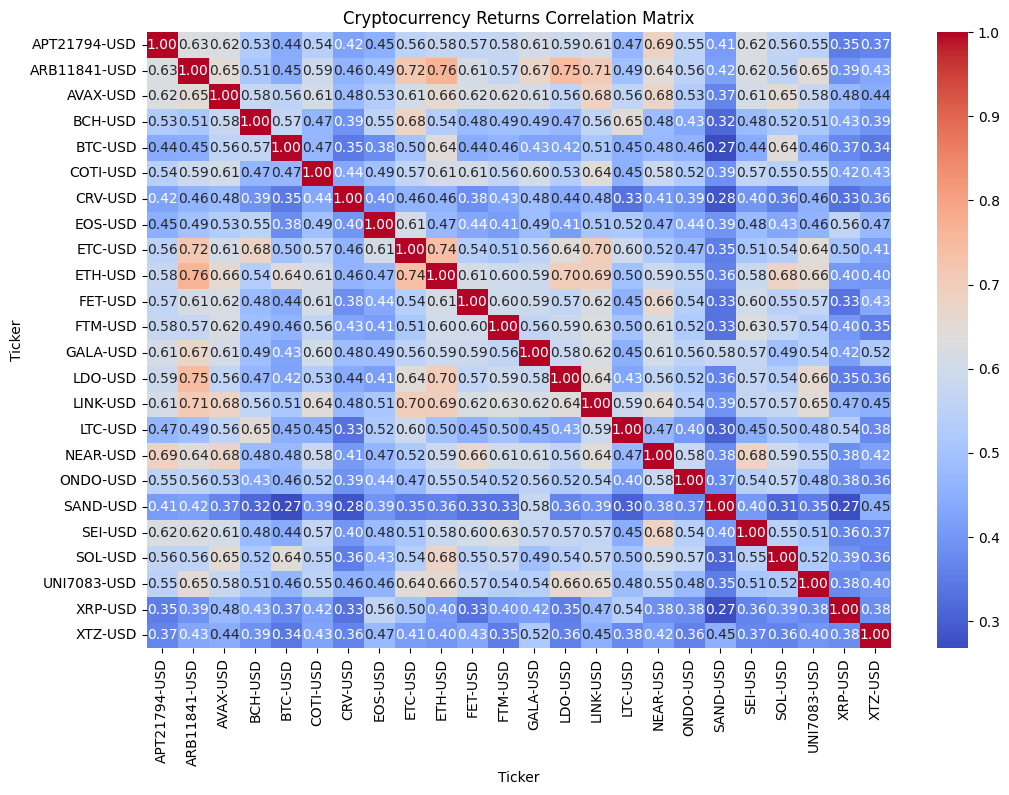

In [30]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [31]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
APT21794-USD          13.0213          12.2419        14.9045        15.6839
ARB11841-USD           1.0671           0.9922         1.2306         1.3055
AVAX-USD              48.3576          46.0182        54.7465        57.0859
BCH-USD              558.6100         534.5140       629.6887       653.7847
BTC-USD            95005.3166       92988.8408    100251.4334    102267.9092
COTI-USD               0.1678           0.1589         0.1950         0.2039
CRV-USD                1.0030           0.9270         1.1936         1.2696
EOS-USD                1.2632           1.1934         1.4592         1.5290
ETC-USD               34.2819          32.6195        38.8520        40.5144
ETH-USD             3724.2324        3616.8205      4005.4107      4112.8226
FET-USD                1.8531           1.7457  

In [39]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
  "BTC-USD": 000,
  "BCH-USD": 3,
  "SOL-USD": 000,
  "APT21794-USD": 00,
  "ARB11841-USD": 800,
  "AVAX-USD": 30,
  "COTI-USD": 6000,
  "CRV-USD": 2500,
  "EOS-USD": 00,
  "ETC-USD": 30,
  "ETH-USD": 0.5,
  "FET-USD": 500,
  "FTM-USD": 750,
  "GALA-USD": 00000,
  "LDO-USD": 800,
  "LINK-USD": 000,
  "LTC-USD": 10,
  "NEAR-USD": 150,
  "ONDO-USD": 000,
  "SAND-USD": 000,
  "SEI-USD": 0000,
  "UNI7083-USD":100,
  "XRP-USD": 0000,
  "XTZ-USD": 000,


})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

crypto_symbols = list(weights.index)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 5.50%
Daily Portfolio Mean: 3.04%
95% VaR (daily, value): $1,715.21 (9.04%)
Portfolio_Value: 18,972.42


In [40]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BCH-USD : $192.60 (1.02%)
ARB11841-USD : $107.13 (0.56%)
AVAX-USD : $167.22 (0.88%)
COTI-USD : $147.11 (0.78%)
CRV-USD : $424.57 (2.24%)
ETC-USD : $118.37 (0.62%)
ETH-USD : $120.51 (0.64%)
FET-USD : $120.45 (0.63%)
FTM-USD : $139.66 (0.74%)
LDO-USD : $232.46 (1.23%)
LTC-USD : $159.39 (0.84%)
NEAR-USD : $136.41 (0.72%)
UNI7083-USD : $190.63 (1.00%)

Total 95% VaR (daily, value): $2256.50


In [41]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD","BCH-USD", "SOL-USD","XRP-USD", "ETH-USD"]
second_group = ["APT21794-USD","ARB11841-USD", "AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD", "ETC-USD", "FET-USD",
               "FTM-USD","GALA-USD","LDO-USD","LTC-USD","LINK-USD","NEAR-USD", "ONDO-USD","SAND-USD", "SEI-USD", "UNI7083-USD", "XTZ-USD"]

# crypto_symbols 리스트 중복 제거
crypto_symbols = list(set(first_group + second_group))

crypto_symbols = first_group + second_group

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.8},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.2}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x, index=crypto_symbols) # index 추가
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{optimal_weights.index[i]}: {weight:.1%}") #index 사용

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
BCH-USD: 16.2%
SOL-USD: 16.1%
ETH-USD: 16.1%
BTC-USD: 15.8%
XRP-USD: 15.8%
ARB11841-USD: 1.3%
UNI7083-USD: 1.3%
NEAR-USD: 1.3%
XTZ-USD: 1.1%
AVAX-USD: 1.1%
FET-USD: 1.1%
LINK-USD: 1.1%
LDO-USD: 1.0%
ETC-USD: 1.0%
SEI-USD: 1.0%
APT21794-USD: 1.0%
GALA-USD: 1.0%
CRV-USD: 1.0%
LTC-USD: 1.0%
FTM-USD: 1.0%
COTI-USD: 1.0%
ONDO-USD: 0.9%
SAND-USD: 0.9%
EOS-USD: 0.9%

Expected Daily Return: 2.32%
Daily Volatility: 4.93%
Sharpe Ratio: 0.47
